# Tutorial on PySpark DataFrames and SparkSQL

##  Activity: Parallel Search

For this tutorial, we will focus on parallel search in Big Data. Thus, the following sections will be done:
1. Review Data partitioning strategies
2. Implement distinct searching functionalities using RDDs: 
3. Implement distinct searching functionalities using Spark SQL module: you will use the Spark API to use dataframes and Spark SQL to perform the search functionality as in section 1.


Also, you will need to  visualise the parallelism on searching in these APIs and RDD implementation. Furthermore, you will need to look at the Query execution plan done by the Spark Optimizer Engine and understand how internally Spark executes or plans a searching function.

Let's get started.

## Table of Contents

* [SparkContext and SparkSession](#one)
* [Data Partitioning](#two)
* [Spark RDDs](#three)
    * [Data Partitioning in RDD](#three)
        * [Default Partitioning](#default)
        * [Hash Partitioning](#hash)
        * [Range Partitioning](#range)
    * [Parallel Search in RDDs](#parallel-search-rdd)    
* [Spark DataFrames](#dataframes)
    * [Data Partitioning in DataFrames](#df-partitioning)
    * [Parallel Search in DataFrames](#parallel_search_df)    
    * [Parallel Search with SparkSQL](#parallel_search_sparksql)       
* [Lab Tasks](#lab-task-1)
    * [Lab Task 1](#lab-task-1)
    * [Lab Task 2](#lab-task-2)
    * [Lab Task 3](#lab-task-3)
    * [Lab Task 4](#lab-task-4)
    * [Lab Task 5](#lab-task-5)
    * [Lab Task 6](#lab-task-6)


## SparkContext and SparkSession <a class="anchor" name="one"></a>

In [ ]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Parallel Search"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

# # Method 2: Getting or instantiating a SparkContext
# sc = SparkContext.getOrCreate(spark_conf)
# sc.setLogLevel('ERROR')

## Data Partitioning <a class="anchor" id="two"></a>
In this first part of the tutorial, we will do a quick review of a few data partitioning strategies which we will need to know for the rest of the topics in this tutorial.

Data partitioning is the fundamental step for parallel search algorithms as parallelism in query and search processing is achieved through data partionining. 
In this activity, we will consider the following **three** partitioning strategies:
#### 1. Round-robin data partitioning ###
Round-robin data partitioning is the simplest data partitioning method in which each record in turn is allocated to a processing element (simply processor). Since it distributes the data evenly among all processors, it is also known as "equal-partitioning".

#### 2. Range data partitioning ###
Range data partitioning records based on a given range of the partitioning attribute. For example,the student table is partitioned based on "Last Name" based on the alphabetical order (i.e. A ~ Z). 

#### 3. Hash data partitioning ###
Hash data partitioning makes a partition based on a particular attribute using a hash function. The result of a hash function determines the processor where the record will be placed. Thus, all records within a partition have the same hash value.

## RDD partitioning <a class="anchor" id="three"></a>

By default, Spark partitions the data using <strong>Random equal partitioning</strong> unless there are specific transformations that uses a different type of partitioning</strong>
In the code below, we have defined two functions to implement custom partitioning using <strong>Range Partitioning</strong> and <strong>Hash Partitioning</strong>.


In [ ]:
from pyspark.rdd import RDD

#A Function to print the data items in each RDD
#Same function is used to print out the data items of a DataFrame later
def print_partitions(data):
    if isinstance(data, RDD):
        numPartitions = data.getNumPartitions()
        partitions = data.glom().collect()
    else:
        numPartitions = data.rdd.getNumPartitions()
        partitions = data.rdd.glom().collect()
    
    print(f"####### NUMBER OF PARTITIONS: {numPartitions}")
    for index, partition in enumerate(partitions):
        # show partition if it is not empty
        if len(partition) > 0:
            print(f"Partition {index}: {len(partition)} records")
            # TODO: You can complete the code to show the values or some values for each partition
            print(partition)

In [ ]:
#Sample data used for demonstrating the partitioning
list_tutors = [(1,'Aaditya'),(2,'Chinnavit'),(3,'Neha'),(4,'Huashun'),(5,'Mohammad'),
                (10,'Peter'),(11,'Paras'),(12, 'Tooba'),(3, 'David'),(18,'Cheng'),(9,'Haqqani')]

#Define the number of partitions
no_of_partitions = 4

### Default Partitioning in Spark RDD <a class="anchor" id="default"></a>

In [ ]:
# random equal partition
rdd = sc.parallelize(list_tutors, no_of_partitions)

In [ ]:
print("Number of partitions:{}".format(rdd.getNumPartitions()))
print("Partitioner:{}".format(rdd.partitioner))
print_partitions(rdd)  

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>How do you think the data is divided across the partitions by default when no partitoner is specified?</div>

### Hash Partitioning in RDD <a class="anchor" id="hash"></a>
Hash partitioning uses the formula <code>partition = hash_function() % numPartitions</code> to determine which partition data item falls into.

In [ ]:
#Hash Function to implement Hash Partitioning 
#Just computes the sum of digits
#Example : hash_function(12) produces 3 i.e. 2 + 1
def hash_function(key):
    total = 0
    for digit in str(key):
        total += int(digit)
    return total

In [ ]:
# hash partitioning
hash_partitioned_rdd = rdd.partitionBy(no_of_partitions, hash_function)
print_partitions(hash_partitioned_rdd)            

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">Note: </strong>Look at how the data is partitioned. For example, Partition 0 has 1 record, [(4, 'Huashun')]. Here is the step-wise breakdown:
    <ul>
        <li>hash_function(4) = 4</li>
        <li>Partition for the key of 4 is determined by <code>hash_function(4)%numPartitions</code> i.e. 4%4=0</li>
        <li>Similarly, for (18,'Cheng'), partition is given by <code>hash+function(18)%numPartitions</code> i.e. 9%4=1</li>
    </ul>

</div>

### Range Partitioning in RDD <a class="anchor" id="range"></a>
This strategy uses a range to distribute the items to respective partitions when the keys fall within the range. 

In [ ]:
no_of_partitions=4

#Find the size of the elements in RDD
chunk_size = len(list_tutors)/no_of_partitions
#Define a range of values by key to distribute across partitions
#Here for simplicity, we are defining the range i.e. keys from 1-4 to fall in first partition, 5-9 in second partition and so on
range_arr=[[1,4],[5,9],[10,14],[15,19]]

def range_function(key):
    for index,item in enumerate(range_arr):
        if key >=item[0] and key <=item[1]:
            return index


In [ ]:
# range partition
range_partitioned_rdd = rdd.partitionBy(no_of_partitions, range_function)
print_partitions(range_partitioned_rdd)

## Parallel Search using RDDs  <a class="anchor" id="parallel-search-rdd"></a>

Now we will implement basic search functionalities and visualise the parallelism embedded in Spark to perform these kind of queries.

In this tutorial, you will use a csv dataset **bank.csv**. However, for this tutorial we won't analyse the case study but only perform some search queries with this data

In [ ]:
# Using Spark, we can read and load a csv file
# Read csv file and load into an RDD object
bank_rdd = sc.textFile('bank.csv')

# If you want to specify the number of partitions, you can add the number as a second argument
# bank_rdd = sc.textFile('bank.csv', 10)

## Exploring the data file, we can see that it contains different types of information
## Some useful information is printed below
print(f"Total partitions: {bank_rdd.getNumPartitions()}")
print(f"Number of lines: {bank_rdd.count()}")

## Each element of the RDD is a line from the file
bank_rdd.take(4)

### Search in RDDs based on multiple conditions

We will focus on only four attributes from the data: age, education, marital and balance for filtering conditions. However, we will display additional information as well.

In [ ]:
# 1. Split each line separated by comma into a list 
bank_rdd1 = bank_rdd.map(lambda line: line.split(','))
# 2. Remove the header
header = bank_rdd1.first()
bank_rdd1 = bank_rdd1.filter(lambda row: row != header)   #filter out header

# Indices for each attribute we will use
# Filter: age, education, marital, balance = 0, 3, 2, 5
# Display additional: day, month, deposit = 9, 10, 16

# 3. Search the records with balance between 1000 and 2000
bank_rdd1 = bank_rdd1.filter(lambda x: int(x[5])>1000 and int(x[5])<2000)
# 4. Also search the records with primrary or secondary education and age less than 30
bank_rdd1 = bank_rdd1.filter(lambda x: x[3] in ['primary','secondary'] and int(x[0])<30)
# 5. Also filter with those who are married
bank_rdd1 = bank_rdd1.filter(lambda x: x[2]=='married' )
# 6. Display the previous attributes plus the information of day, month and deposit
bank_rdd1 = bank_rdd1.map(lambda field: (field[0],field[2],field[3],field[5],
                                         field[9],field[10],field[16]))
# Print how many final records
print(bank_rdd1.count())

In [ ]:
# Let's see how the data was divided and the data for each partition
numPartitions = bank_rdd1.getNumPartitions()
print(f"Total partitions: {numPartitions}")

# glom(): Return an RDD created by coalescing all elements within each partition into a list
partitions = bank_rdd1.glom().collect()
for index,partition in enumerate(partitions):
    print(f'------ Partition {index}:')
    for record in partition:
        print(record)

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>Verify the parallelism in the Spark UI and explore the content. How many jobs have been executed so far?</div>

### Searching max/min value of an attribute in an RDD
This task will aim to find the record in the dataset that contains the highest value for a given attribute. In this case the attribute chosen is "balance".

In [ ]:
# Read csv but now with 4 partitions
bank_rdd_4 = sc.textFile('bank.csv',4)

# Split and remove the header
bank_rdd_4 = bank_rdd_4.map(lambda line: line.split(','))
header = bank_rdd_4.first()
bank_rdd_4 = bank_rdd_4.filter(lambda row: row != header)   #filter out header

# Display the first 3 records
bank_rdd_4.take(3)

In [ ]:
# Using the RDD function max(), it can be obtained in a single line 
result_max_balance = bank_rdd_4.max(key=lambda x: x[5]) # Get max by value in index 5 (balance)
# Print the record obtain with highest balance
print(result_max_balance)

In [ ]:
# Get record with balance 10576
bank_record = bank_rdd_4.filter(lambda x: x[5]=='10576').collect()
print(bank_record)

<a class="anchor" id="lab-task-1"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">1. Lab Task: </strong>Compare the <code>result_max_balance</code> record with the record above <code>(bank_record)</code>. Was the record obtained previously correct i.e. <code>result_max_balance</code>? <b>Explain what happened.</b></div>


In [ ]:
result_max_balance = bank_rdd_4.max(key=lambda x: x[5])

<a class="anchor" id="lab-task-2"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">2. Lab Task: </strong>As you noticed in the previous result, the record returned originally (result_max_balance) was incorrect.
    <p><i>Fix the code below that uses the <code>max()</code> function to get the record with the correct maximum balance.</p></i></div>


#### To learn more about functions in RDDs, you can look into the next 2 sites:
1. http://spark.apache.org/docs/latest/rdd-programming-guide.html#rdd-operations
1. https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_Cheat_Sheet_Python.pdf

## DataFrames in Spark <a class="anchor" id="dataframes"></a>
A DataFrame is a distributed collection of data organized into named columns. It is equivalent to a table in relational database or a dataframe in R/Python but with richer optimizations under the hood. For more information visit : 

https://docs.databricks.com/spark/latest/dataframes-datasets/introduction-to-dataframes-python.html

### Creating DataFrames
SparkSession provides an easy method <code>createDataFrame</code> to create Spark DataFrames. Data can be loaded from csv, json, xml and other sources like local file system or HDFS. More information on : 
https://spark.apache.org/docs/latest/api/python/pyspark.sql.html

To display the schema, i.e. the  structure of the DataFrame, you can use <strong>printSchema()</strong> method.

In [ ]:
df = spark.createDataFrame([(1,'Aaditya','A'),(2,'Chinnavit','C'),(3,'Neha','N'),(4,'Huashun','H'),(5,'Mohammad','M'),
                            (10,'Prajwol', 'P'),(1,'Paras','P'),(1, 'Tooba','T'),(3, 'David','D'),(4,'Cheng','C'),(9,'Haqqani','H')],
                           ['Id','Name','Initial'])

#display the rows of the dataframe
df.show(5)
#view the schema
df.printSchema()

Another way to create a DataFrame is use the <strong>spark.read.csv</strong> file to load the data from csv to a DataFrame

In [ ]:
df = spark.read.csv("bank.csv",header=True)

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>Display first 10 rows of the above dataframe. 
Try out other dataframe methods:    
    <ul>
        <li><code>df.columns, df.count()</code></li>
        <li><code>df.describe('column_name').show()</code></li>
        <li><strong>Selecting:</strong><code>df.select('column_name').show(), df.select('column_name').distinct().show()</code>
        </li>
        <li><strong>Filtering:</strong><code>df.filter(df.column_name == 123).show()</code></li>
</div>

### Partitioning in DataFrames <a class="anchor" id="df-partitioning"></a>

In [ ]:
df = spark.createDataFrame([(1,'Aaditya','A'),(2,'Chinnavit','C'),(3,'Neha','N'),(4,'Huashun','H'),(5,'Mohammad','M'),
                            (10,'Prajwol', 'P'),(1,'Paras','P'),(1, 'Tooba','T'),(3, 'David','D'),(4,'Cheng','C'),(9,'Haqqani','H')],
                           ['Id','Name','Initial'])

In [ ]:
# Round-robin data partitioning
df_round = df.repartition(2)
# Range data partitioning
df_range = df.repartitionByRange(2, "Initial")
# Hash data partitioning
column_hash = "Id"
df_hash = df.repartition(column_hash)

In [ ]:
print_partitions(df_round)

In [ ]:
print_partitions(df_range)

In [ ]:
print_partitions(df_hash)

In [ ]:
# Read csv file and load into a dataframe
df = spark.read.csv("bank.csv",header=True)

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong> How many partitions the dataframe have?</div>

<a class="anchor" id="lab-task-3"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:##FF5555">3. Lab Task: </strong> Implement Range and Hash Partitioning techniques for the new dataset and display the partitions. COMPLETE THE CODE BELOW.</div>

In [ ]:
## We can specify how many partitions or what kind of partitioning we want for a dataframe
# Round-robin data partitioning
df_round = 
# Range data partitioning , partition by 'balance'
df_range = 
# Hash data partitioning
column_hash = "education"
df_hash = 

In [ ]:
## Print the number of partitions for each dataframe
print(f"----- NUMBER OF PARTITIONS df_round: {df_round.rdd.getNumPartitions()}")
print(f"----- NUMBER OF PARTITIONS df_range: {df_range.rdd.getNumPartitions()}")
print(f"----- NUMBER OF PARTITIONS df_hash: {df_hash.rdd.getNumPartitions()}")

## Verifying the number of partitions for the dataframe with hash partitioning it would indicate 200.
## One important thing is that by default, when the number of partitions are not indicated,
## The default number of partitions is 200

## However, most of the partitions for df_hash are empty.
## We can verify by using the following function

## df is the dataframe to show its information
def print_partitions(df):
    numPartitions = df.rdd.getNumPartitions()
    print(f"####### NUMBER OF PARTITIONS: {numPartitions}")
    partitions = df.rdd.glom().collect()
    for index,partition in enumerate(partitions):
        # show partition if it is not empty
        if len(partition)>0:
            print(f"Partition {index}: {len(partition)} records")
            # TODO: You can complete the code to show the values or some values for each partition
            

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong> Complete the above code to show the values for each partition</div>

In [ ]:
## You can verify the partitioning and the query plan when an action is performed with the function explain()
# Query plan for df_round
df_round.explain()
# Query plan for df_range
df_range.explain()
# Query plan for df_hash
df_hash.explain()

### Parallel Search using Spark Dataframe <a class="anchor" id="parallel_search_df"></a>

We will perform the same filtering criteria as in section 1. This time the logic won't be implemented by us but just declare by using the functions of the Spark Dataframe API to perform the same queries. Thus, we should obtain the same results as before.

Furthermore, now you will need to see in the Spark UI, the RDD DAG Visualisation and the Execution Plan of the queries performed with the function explain() as we did previously.

<a class="anchor" id="lab-task-4"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:##FF5555">4. Lab Task: </strong> Complete the code in the given cell below to implement the given conditions.</div>

In [ ]:
# Using the Spark Dataframe API we can obtain the dataframe for a csv file
# We already created dataframes with different types of partitioning
# Choose one of them to work with and perform the queries made in section 1
from pyspark.sql.functions import col

bank_df = df_round

## The functions to filter in dataframes are similar to the functions in RDD. Thus, the steps are:
# 1. Search the records with balance between 1000 and 2000
bank_df = bank_df.filter(col("balance")>1000)\
            .filter(col("balance")<2000)
# TODO: 
# 2. Also in the same dataframe, search the records with primary or secondary education and age less than 30
bank_df =

# TODO:
# 3. Also filter with those who are married
bank_df = 


# TODO:
# 4. Display the previous attributes plus the information of day, month and deposit
bank_df = 


# 5. Display the records
bank_df.show()

In [ ]:
#### Query and partition information
print_partitions(bank_df)
#### Execution Plan for query with multiple filter conditions
bank_df.explain()

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong> Repeat the same query with different partitioning strategies <strong>(Round-Robin, Range and Hash)</strong> and compare its query execution plan plus its information in the <strong>Spark UI.</strong> </div>

<a class="anchor" id="lab-task-5"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:##FF5555">5. Lab Task: </strong>Obtain also the <code>max/min</code> as you did in RDDs but now using <strong>Spark DataFrame</strong>. Does it return the same value as in section 1? Also, check its execution plan and the information in Spark UI.</div>

### Parallel Search using SQL language in Spark  <a class="anchor" id="parallel_search_sparksql"></a>
#### Spark SQL
Spark SQL is a Spark module for structured data processing. It provides a programming abstraction called DataFrames and can also act as a distributed SQL query engine. It enables unmodified Hadoop Hive queries to run up to 100x faster on existing deployments and data. It also provides powerful integration with the rest of the Spark ecosystem (e.g., integrating SQL query processing with machine learning). <a href="https://databricks.com/glossary/what-is-spark-sql#:~:text=Spark%20SQL%20is%20a%20Spark,on%20existing%20deployments%20and%20data">[Read More]</a>.

A view can be created from a dataframe in order to use SQL queries to search data. In this section, you will use SQL statements to perform search queries in the views that will be registered from the dataframes we created in the previous section.

In [ ]:
# register the original DataFrame as a temp view so that we can query it using SQL
df.createOrReplaceTempView("df_sql")
filter_sql = spark.sql('''
  SELECT age,education,balance,day,month,deposit
  FROM df_sql
  WHERE balance between 1000 and 2000
  AND education in ('secondary','primary')
  AND age < 30
  AND marital = 'married'
''')
# filter_sql.explain()
filter_sql.collect()

<a class="anchor" id="lab-task-6"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">6. Lab Task: </strong>Obtain also the <code>max/min</code> as you did in RDDs and DataFrames, but now using <strong>Spark SQL</strong>. Does it return the same value as in previous cases? Also, check its execution plan and the information in Spark UI.</div>

**Congratulations on finishing this activity!**

Having practiced today's activities, we're now ready to embark on a trip of the rest of exiciting FIT5202 activities! See you next week!

##  Activity: Parallel Aggregation

For this tutorial we will implement different operations and aggregations like distinct, group by and order by on Spark DataFrames. In the second part, you will need to use all these operations to answer the lab tasks.

Let's get started.


## Table of Contents

* [SparkContext and SparkSession](#one)
* [Parallel Aggregation](#two)
    * [Group By](#groupby)        
    * [Sort By](#sortby)    
    * [Distinct](#distinct)    
* [Miscellaneous DataFrame Operations](#misc)
    * [Describe a column](#describe_column)
    * [Adding/Dropping Columns](#add_drop_column)    
    * [PySpark Built-in Functions](#pyspark_functions)       
    * [User Defined Functions : UDFs](#udf) 
* [Lab Tasks](#lab-task-1)
    * [Lab Task 1](#lab-task-1)
    * [Lab Task 2](#lab-task-2)
    * [Lab Task 3](#lab-task-3)    

<a class="anchor" name="one"></a>
## Import Spark classes and create Spark Context

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>In the cell block below, 
<ul>
    <li>Create a SparkConfig object with application name set as "Parallel Aggregation"</li>
    <li>specify 2 cores for processing</li>
    <li>Use the configuration object to create a spark session named as <strong>spark</strong>.</li>
    </ul>
    
<p><strong style="color:red">Important:</strong> You cannot proceed to other steps without completing this.</p>
</div>

In [ ]:
# TODO: Import libraries needed from pyspark

# TODO: Create Spark Configuration Object

# TODO: Create SparkSession

<a class="anchor" name="two"></a>
## Parallel Aggregation

Now we will implement basic aggregation functionalities and visualise the parallelism embedded in Spark as well as the execution plan and functions done to perform these kind of queries.

In this tutorial, you will use two csv files as datasets which contains information about all the athletes that have participated in the Summer and Winter Olympics (athlete_events.csv) as well as the information of their countries (noc_regions.csv).

In [ ]:
# Read athlete events data as dataframe
df_events = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('athlete_events.csv')

# Create Views from Dataframes
df_events.createOrReplaceTempView("sql_events")

## Verifying the number of partitions for each dataframe
## You can explore the data of each csv file with the function printSchema()
print(f"####### DICTIONARY INFO:")
print(f"Number of partitions: {df_events.rdd.getNumPartitions()}")
df_events.printSchema()

### Group By <a class="anchor" name="groupby"></a>
This part contains a simple aggregation query. Look into the query plan and level of parallelism in the Spark UI.

In [ ]:
import pyspark.sql.functions as F

#### Aggregate the dataset by 'Year' and count the total number of athletes using Dataframe
agg_attribute = 'Year'
df_count = df_events.groupby(agg_attribute).agg(F.count(agg_attribute).alias('Total'))

#### Aggregate the dataset by 'Year' and count the total number of athletes using SQL
sql_count = spark.sql('''
  SELECT year,count(*)
  FROM sql_events
  GROUP BY year
''')

In [ ]:
df_count.take(5)

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">NOTE: </strong>
  The same thing can be done using 
    <code>groupby(agg_attribute).agg({'Year':'count'})</code>    
</div>

### Sort By <a class="anchor" name="sortby"></a>
We can use orderBy operation to sort the dataframe based on some column.
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">NOTE: </strong>
    You can specify the sort order using the method <strong>desc()</strong>
    <code>orderBy(df_events.Year.desc())</code>    
</div>


In [ ]:
df_events.select('Year','Name','Team').orderBy(df_events.Year).show(15)

### Distinct <a class="anchor" name="distinct"></a>
This part contains a simple query to get the distinct values of one of the attributes and then sorting them by the same attribute in ascending order.
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">NOTE: </strong>
    We can use <code>.sort()</code> method to do the sorting as well. In the second parameter of the method, we can specify the order of the sorting.
</div>

In [ ]:
#### Get the distinct values for 'Year' in the dataset using Dataframe
df_distinct_sort = df_events.select('Year').distinct().sort('Year', ascending=True)

#### Get the distinct values for 'Year' in the dataset using SQL
sql_distinct_sort = spark.sql('''
  SELECT distinct Year
  FROM sql_events
  ORDER BY year
''')
df_distinct_sort.take(10)

<a class="anchor" id="lab-task-1"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">1. Lab Task: </strong>Sort the above dataframe i.e. events by <strong>Year</strong> in descending order.</div>


<a class="anchor" name="misc"></a>
## Miscellaneous Dataframe Operations
These are the examples of other dataframe operations which are useful.

### Describing a Column <a class="anchor" name="describe_column"></a>
The <code>describe()</code> melthod gives the statistical summary of the column. If the column is not specified, it gives the summary of the whole dataframe.

In [ ]:
df_events.describe('Team').show()

### Adding and Dropping a column in dataframe <a class="anchor" name="add_drop_column"></a>

In [ ]:
#Here is an example of adding a new column based on the previous column
df_events_new = df_events.withColumn('Years Ago',2020-df_events.Year).select('Years Ago','Name')
display(df_events_new)

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>
    You can use the <code>.drop('column_name')</code> method to drop columns from a dataframe. Try this method and drop the column created above.
</div>

### Using PySpark Functions <a class="anchor" name="pyspark_functions"></a>
You can use PySpark built-in functions along with the <code>withColumn()</code> API.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

#Changing the datatype 
#using the display method to see the columns and datatypes of a dataframe
display(df_events)

In [ ]:
#use CAST to change the datatype of Age Column 
df_events = df_events.withColumn('Age',F.col('Age').cast(IntegerType()))
display(df_events)

In [ ]:
#The folowing example uses another inbuilt function to extract year from the Games column
df_events = df_events.withColumn('Games Year',F.split(df_events.Games,' ')[0])
df_events.select('Games Year').show(5)

### DataFrame UDFs (User Defined Functions) <a class="anchor" name="udf"></a>
Similar to map operation in an RDDs, sometimes we might want to apply a complex operation to the DataFrame, something which is not provided by the DataFrame APIs. In such scenarios, using a Spark UDF could be handy. To use Spark UDFs, we need to use the F.udf to convert a regular function to a Spark UDF.


In [ ]:
#For example, the following function does the same things as the above built-function but this time we are using a udf
#1. The function is defined
def extract_year(s):
    return int(s.split(' ')[0])

#2. Calling the UDF with DataFrame
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

#First Register the function as UDF
extract_year_udf = udf(extract_year,IntegerType())

#Call the function
df_events.select('Games',extract_year_udf('Games').alias("Game Year")).show(5)

#4. Calling with Spark SQL
#First Register the function as UDF
spark.udf.register('extract_year',extract_year,IntegerType())

#Call the function 
df_events.createOrReplaceTempView('events')
df_sql = spark.sql('''select Games, extract_year(Games) as Game_Year from events''')
df_sql.show(5)

## Combining DataFrame operations <a class="anchor" name="combine"></a>
Now that we have used the main SQL operations to process data, you will implement several queries using Spark Dataframes and SQL to solve each of the queries.
The dataset used for this section will be the 2 attached csv files:
* <code>athlete_events.csv</code>
* <code>noc_regions.csv</code>

The first dataset was already used in the first part of this tutorial. The second one contains the countries with some additional information
In this section, you will need to complete most of the code but in some parts, a hint or the name of variables will be given.

In [ ]:
# Stop the previous Spark Context to clean all the previous executions from the previous section
sc.stop()
# Verify that the Spark UI is not running anymore or that there is no content

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>
Since we have removed the Spark Context in the previous code block, start the context once again by using the SparkSession object in the next code block.
</div>

In [ ]:
# TODO: Import libraries needed from pyspark

# TODO: Create Spark Configuration Object

# TODO: Create SparkSession

### Create Spark data objects (Dataframes and SQL)

In [ ]:
# Read athlete events data as dataframe
df_events = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('data/athlete_events.csv')

# TODO: Read noc regions (countries) data as dataframe
df_regions = spark.read.format('csv')\
            .option('header',True)\
            .load('data/noc_regions.csv')

# Create Views from Dataframes
df_events.createOrReplaceTempView("sql_events")
df_regions.createOrReplaceTempView("sql_regions")

# View Schema for both dataframes
df_events.printSchema()
df_regions.printSchema()

### Queries/Anaysis
For this part, you will need to implement the Dataframe operations and/or the SQL queries to obtain the reports needed for the following questions:

<a class="anchor" id="lab-task-2"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">2. Lab Task: </strong>Get total number of male athletes per year of the 2000s order by ascending year. <strong>Sample Output:</strong>
<pre>
+----+------------------+
|year|number_of_athletes|
+----+------------------+
|2000|             XXXXX|
|2002|              XXXX|
</pre>
</div>


<a class="anchor" id="lab-task-3"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">3. Lab Task: </strong> Get total number of athletes per Olympic event (summer/winter) in the 1990s decade for Australia and New Zealand. <strong>Sample Output:</strong>
<pre>
+-----------+------+------------------+
|    country|season|number_of_athletes|
+-----------+------+------------------+
|  Australia|Summer|               XXX|
</pre>
</div>


<a class="anchor" id="lab-task-4"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>Obtain the minimum, average and maximum height of each country for the Winter Olympics and order by the average value in descending order. <strong>Output should be in the following format:</strong>
<pre>
+--------------------+----------+------------------+----------+
|             country|min_height|        avg_height|max_height|
+--------------------+----------+------------------+----------+
</pre>
</div>


<a class="anchor" id="lab-task-5"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong> Get the Olympics teams that don't have information of their countries in noc_regions (e.g. Soviet Union since it doesn't exist anymore). <strong>Output should be in the following format:</strong>
<pre>
+--------------------+---+
|                team|noc|
+--------------------+---+
|               Almaz|URS|
|         Australasia|ANZ|
</pre>
</div>


**Congratulations on finishing this activity!**

##  Activity: Parallel Joins in Spark DataFrames

For this tutorial we will look at the high level join strategies used in Spark while performing join operation. We will try to understand the interal working of these strategies by examining the query execution plan and the graphical plan provided in Spark UI. We will then look into various other basic join algorithms used by Spark.

Let's get started.


## Table of Contents

* [SparkContext and SparkSession](#one)
* [Parallel Join Strategies](#parallel-join)
    * [Broadcast Hash Join](#bhj)
    * [Sort Merge Join](#smj)
* [Parallel Joins](#other-joins)
    * [Inner Join](#inner)        
    * [Left Join](#left)        
    * [Full Outer Join](#full_outer)        
    * [Left Semi Join](#left_semi)        
    * [Left Anti Join](#left_anti)            
* [Lab Tasks](#lab-task-1)
    * [Lab Task 1](#lab-task-1)
    * [Lab Task 2](#lab-task-2)
    * [Lab Task 3](#lab-task-3)    

<a class="anchor" id="one"></a>
## Import Spark classes and create Spark Context

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>In the cell block below, initialize the spark session named as <strong>spark</strong> and create the <code>SparkContext</code> names <strong>sc</strong> from that Spark Session.
    
<p><strong style="color:red">Important:</strong> You cannot proceed to other steps without completing this.</p>
</div>

In [ ]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Parallel Join"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkSession classes 
from pyspark.sql import SparkSession # Spark SQL

#TODO : Initialize Spark Session and create a SparkContext Object



<a class="anchor" id="parallel-join"></a>
## Parallel Join Strategies
### Creating  datasets (i.e. dataframes)
In the code below, we are creating two datasets with a common key "id". When we are joining two tables, we need at least 1 common key.

In [ ]:
###### Setting dataset
import random
random.seed(0)

# List of tuples
tableA = [(i,'A'+str(i)) for i in range(100,110)]
tableB = [(i,'B'+str(i)) for i in range(10,1000)]
# Shuffle the lists to not have it ordered
random.shuffle(tableA)
random.shuffle(tableB)

# Converting to dataframe each list of tuples
df_A = spark.createDataFrame(tableA , ["id", "valueA"])
df_A.show()
df_B = spark.createDataFrame(tableB , ["id", "valueB"])
df_B.show()

<a class="anchor" id="bhj"></a>
### 1. Broadcast Hash Join
In this type of join, one dataset(the smaller one) is broadcasted (sent over) to each executor. By doing this, we can avoid the shuffle for the other larger dataset. Not doing the shuffle increase the speed of the join operation.

<i>We need to use the broadcast function inside the join to broadcast the table</i>

In [ ]:
from pyspark.sql.functions import broadcast

# Use broadcast function to specify the use of BroadcastHashJoin algorithm
df_joined_broadcast = df_B.join(broadcast(df_A),df_A.id==df_B.id,how='inner')
df_joined_broadcast.show()

#### Query execution plan

In [ ]:
## Show execution plan using function explain()
df_joined_broadcast.explain()

#### Explanation Query Plan with Broadcast Hash Join
The order of execution goes from top to bottom. The steps are:
1. Scan dataframe A (left side)
  - Filter id not null in dataframe A
2. Scan dataframe B (right side)
  - Filter id not null in dataframe B
3. Broadcast dataframe B: Send dataframe B to each each partition
4. BroadcastHashJoin: Perform join between each partition and the broadcasted dataframe B
5. Project: Select the attributes from both dataframes (df_A: id,valueA and df_b: id,valueB)
6. Collect all the results to the driver

#### Graphical Execution plan in Spark UI
Go to your <strong>Spark UI</strong> and Click on the <strong>SQL</strong> tab to view the graphical equivalent of the above physical plan.
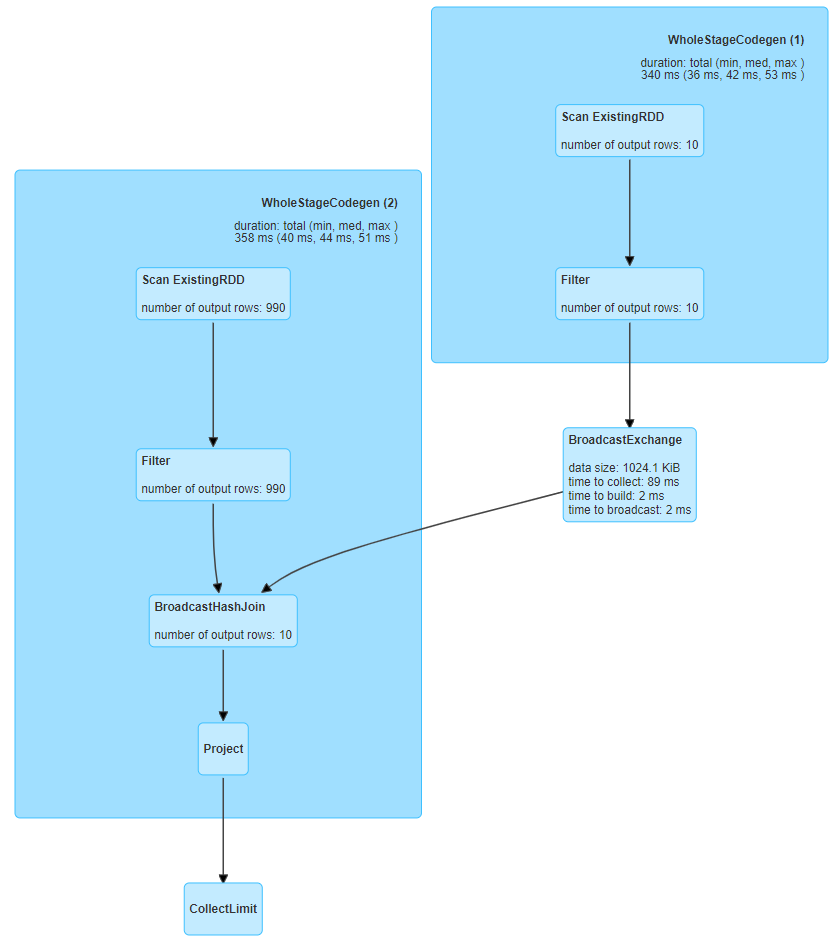

<a class="anchor" id="smj"></a>
### 2. Sort Merge Join
In this join approach, the datasets are sorted first and the second operation merges the sorted data in the partition. This is the <strong>default</strong> join algorithm used by spark.

In [ ]:
df_joined_sortmerge = df_A.join(df_B,df_A.id==df_B.id,how='inner')
df_joined_sortmerge.show()

#### Physical Execution Plan

In [ ]:
df_joined_sortmerge.explain()

#### Graphical Execution Plan in Spark UI
Go to your <strong>Spark UI</strong> and Click on the <strong>SQL</strong> tab to view the graphical equivalent of the above physical plan.
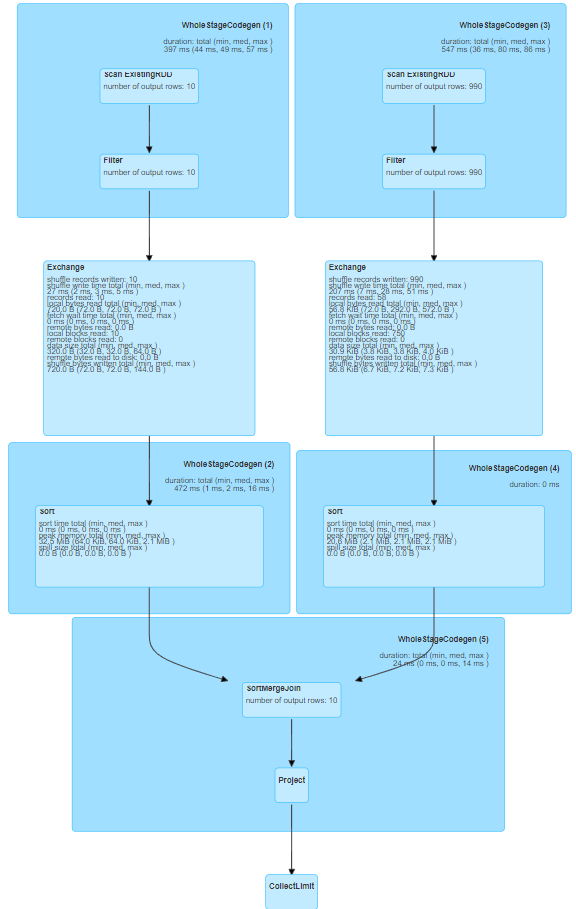

#### Explanation Query Plan with Sort Merge Join
The order of execution goes from top to bottom. The steps are:
1. Scan dataframe A (left side)
  - Filter id not null in dataframe A
2. Scan dataframe B (right side)
  - Filter id not null in dataframe B
3. Exchange dataframe A: Partition dataframe A with hash partitioning
4. Exchange dataframe B: Partition dataframe B with hash partitioning
5. Sort dataframe A: Sort data within each partition
6. Sort dataframe B: Sort data within each partition
7. Perform Sort Merge Join between both dataframes
5. Project: Select the attributes from both dataframes (df_A: id,valueA and df_b: id,valueB)
6. Collect all the results to the driver

<a class="anchor" id="other-joins"></a>
## Parallel Join

Now we will implement multiple join operations and visualise the parallelism embedded in Spark to perform these kind of queries. The join queries that we will perform are:
1. Inner Join
1. Left Join
1. Full Outer Join
1. Left Semi Join
1. Left Anti Join

**All left operations have their right operations as well, but this is a commutative operation so we will focus only on left operations** 

In this tutorial, you will use three csv files as datasets which contains the information of the Summer Olympics (summer.csv) and Winter Olympics (winter.csv) plus the information of the list of countries (dictionary.csv).

In [ ]:
# Read files into dataframes
df_dictionary = spark.read.csv("dictionary.csv",header=True)
df_summer = spark.read.csv("summer.csv",header=True).repartition(4)
df_winter = spark.read.csv("winter.csv",header=True).repartition(4)

# Create Views from Dataframes
df_dictionary.createOrReplaceTempView("sql_dictionary")
df_summer.createOrReplaceTempView("sql_summer")
df_winter.createOrReplaceTempView("sql_winter")

<a class="anchor" id="lab-task-1"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">1. Lab Task: </strong>In the following code block, display the number of partitions and the schema of the above three dataframes. <strong style="color:#FF5555">Examine how the method <code>repartition</code> is used here. What happens if we do not use repartition?</strong></div>


In [ ]:
## Verifying the number of partitions for each dataframe
## You can explore the data of each csv file with the function printSchema()
print(f"####### DICTIONARY INFO:")
##TODO Print number of partitions and schema

print(f"####### SUMMER INFO:")
##TODO Print number of partitions and schema

print(f"####### WINTER INFO:")
##TODO Print number of partitions and schema


<a class="anchor" id="inner"></a>
## 1. Inner Join
This join operation returns the result set that have matching values in both dataframes.

In [ ]:
#### Join summer and dictionary using Dataframes
df_dict_inner_summ = df_dictionary.join(df_summer,df_dictionary.Code==df_summer.Country,how='inner')
print(df_dict_inner_summ.count())
df_dict_inner_summ.show()

## Join summer and dictionary using SQL
sql_dict_inner_summ = spark.sql('''
  SELECT d.*,w.*
  FROM sql_dictionary d JOIN sql_summer w
  ON d.Code=w.Country
''')
print(sql_dict_inner_summ.count())
sql_dict_inner_summ.show()

In [ ]:
# Now look at the exceution plan for the 2 previous objects
df_dict_inner_summ.explain()
sql_dict_inner_summ.explain()

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: </strong>By looking at the Physical Plan, try to understand the internal workings of joins in dataframe. Discuss this with your tutor.</div>

<a class="anchor" id="left"></a>
## 2. Left Join
This join operation returns all records from the left dataframe and the matched records from the right dataframe.

In [ ]:
from pyspark.sql.functions import col

#### Join summer and dictionary using Dataframes
df_dict_left_summ = df_dictionary.join(df_summer,df_dictionary.Code==df_summer.Country,how='left')
# df_dict_inner_summ = df_dict_inner_summ.filter(col('Discipline').isNull())
print(df_dict_left_summ.count())
df_dict_left_summ.show()

## Join summer and dictionary using SQL
sql_dict_left_summ = spark.sql('''
  SELECT d.*,w.*
  FROM sql_dictionary d LEFT JOIN sql_summer w
  ON d.Code=w.Country
''')
print(sql_dict_left_summ.count())
sql_dict_left_summ.show()

In [ ]:
# Now look at the exceution plan for the 2 previous objects
df_dict_left_summ.explain()
df_dict_left_summ.explain()

<a class="anchor" id="full-outer"></a>
## 3. Full Outer Join
This join operation returns a result set that includes rows from both left and right dataframes.

In [ ]:
#### Join summer and dictionary using Dataframes
df_dict_outer_summ = df_dictionary.join(df_summer,df_dictionary.Code==df_summer.Country,how='outer')
print(df_dict_outer_summ.count())
df_dict_outer_summ.show()

## Join summer and dictionary using SQL
sql_dict_outer_summ = spark.sql('''
  SELECT d.*,w.*
  FROM sql_dictionary d FULL OUTER JOIN sql_summer w
  ON d.Code=w.Country
''')
print(sql_dict_outer_summ.count())
sql_dict_outer_summ.show()

In [ ]:
# Now look at the exceution plan for the 2 previous objects
df_dict_outer_summ.explain()
sql_dict_outer_summ.explain()

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE">TODO: Execution plan comparison</strong>
    Now dive into the execution plan of the previous 3 joins and their parallelism
The objects that will be analysed and compared will be:
    <ul>
        <li>df_dict_inner_summ</li>
<li>df_dict_left_summ</li>
<li>df_dict_outer_summ</li>
    </ul>
The comparisons and analysis can be done using the Spark UI. Compare them after running the next code block. If preferred, you can run them one by one to see in the Jobs </div>



In [ ]:
# These actions will execute the Query plan for each of the dataframes
df_dict_inner_summ.collect()
df_dict_left_summ.collect()
df_dict_outer_summ.collect()

## TODO: Look deep into what are the operations performed when an inner join operation is executed.
## For this additional information and better visualisation, go to the Spark UI -> SQL option

<a class="anchor" id="left_semi"></a>
## 4. Left Semi Join
This join operation is like an inner join, but only the left dataframe columns and values are selected

<a class="anchor" id="lab-task-2"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">2. Lab Task: </strong> Implement the <strong>left_semi</strong> join in <strong>Spark SQL.</strong> Ensure that the output from both the approaches is same.</div>


In [ ]:
#### Join summer and dictionary using Dataframes
df_dict_semi_summ = df_dictionary.join(df_summer,df_dictionary.Code==df_summer.Country,how='left_semi')
print(df_dict_semi_summ.count())
df_dict_semi_summ.show()

## TODO: Implement the SQL to perform left semi join between summer and dictionary using SQL


<a class="anchor" id="left_anti"></a>
## 5. Left Anti Join
This join operation is the difference of the left dataframe minus the right dataframe, as it selects all rows from df1 that are not present in df2

<a class="anchor" id="lab-task-3"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">3. Lab Task: </strong> Implement the <strong>left_anti</strong> join in <strong>Spark SQL.</strong> Ensure that the output from both the approaches is same.</div>


In [ ]:
#### Join summer and dictionary using Dataframes
df_dict_anti_summ = df_dictionary.join(df_summer,df_dictionary.Code==df_summer.Country,how='left_anti')
print(df_dict_anti_summ.count())
df_dict_anti_summ.show()

## TODO: Implement the SQL to perform left anti join between summer and dictionary using SQL


**Congratulations on finishing this activity!**